# Online Shopper Purchasing Intention
Group Members: Aaron Zhang, Andrew Arochukwu, Qiguang (William) Zhu

In [1]:
from ucimlrepo import fetch_ucirepo 
import matplotlib.pyplot as plt
import pandas as pd 
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [2]:
# fetch dataset 
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468) 
  
# data (as pandas dataframes) 
X = online_shoppers_purchasing_intention_dataset.data.features 
y = online_shoppers_purchasing_intention_dataset.data.targets 

y = y.astype('int').values.reshape(-1, )
  
# variable information 
print(online_shoppers_purchasing_intention_dataset.variables)

                       name     role         type demographic description  \
0            Administrative  Feature      Integer        None        None   
1   Administrative_Duration  Feature      Integer        None        None   
2             Informational  Feature      Integer        None        None   
3    Informational_Duration  Feature      Integer        None        None   
4            ProductRelated  Feature      Integer        None        None   
5   ProductRelated_Duration  Feature   Continuous        None        None   
6               BounceRates  Feature   Continuous        None        None   
7                 ExitRates  Feature   Continuous        None        None   
8                PageValues  Feature      Integer        None        None   
9                SpecialDay  Feature      Integer        None        None   
10                    Month  Feature  Categorical        None        None   
11         OperatingSystems  Feature      Integer        None        None   

Plotting a histogram of each feature we can see many of the features are skewed, so we will normalize the data with log-scaling. We will also one-hot encode all categorical features.

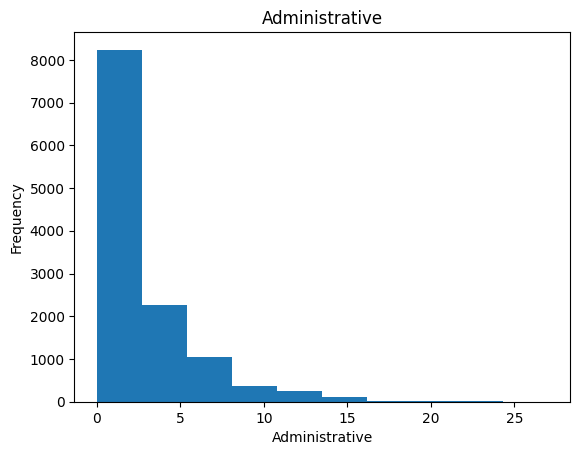

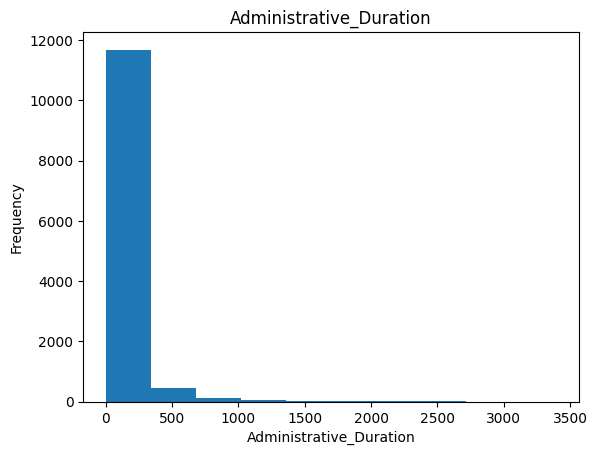

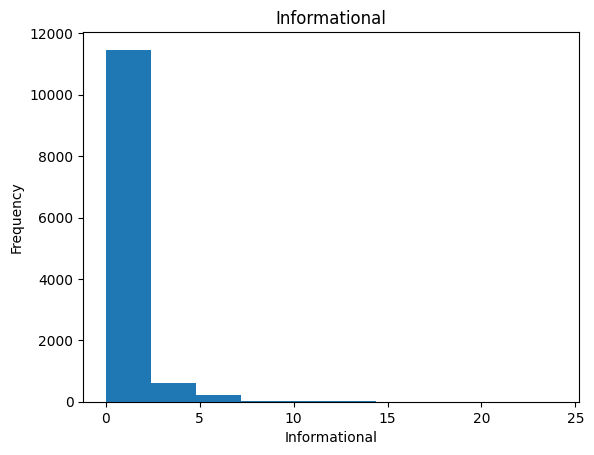

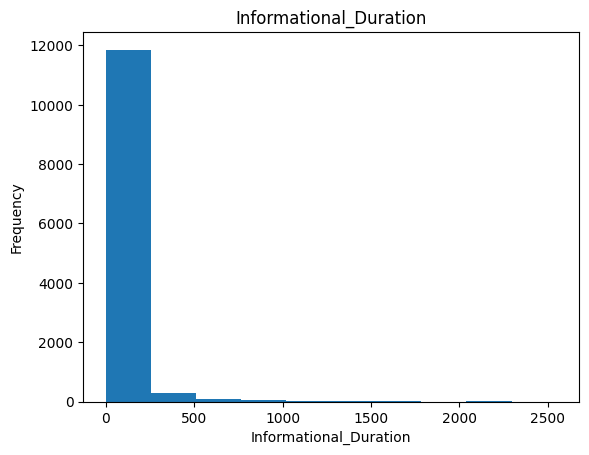

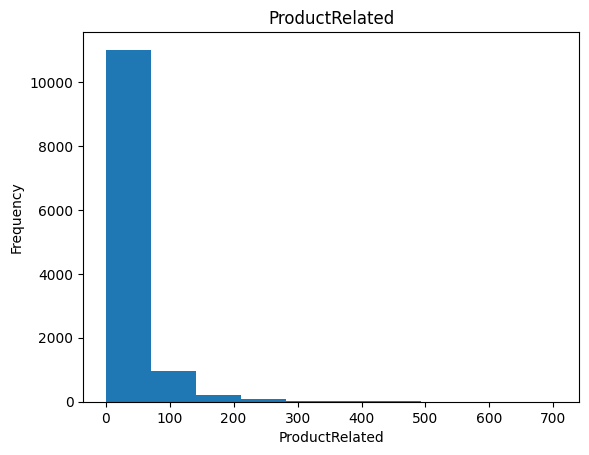

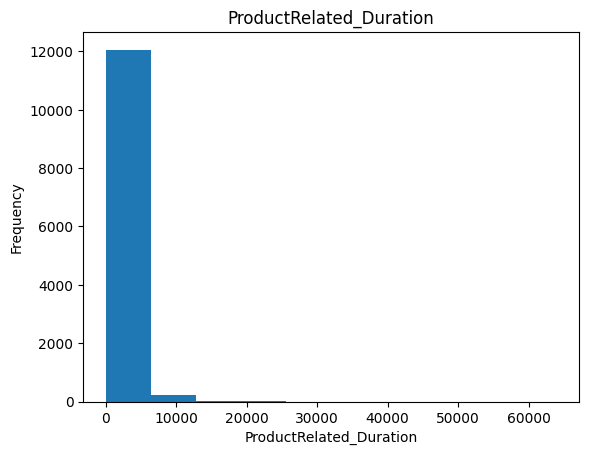

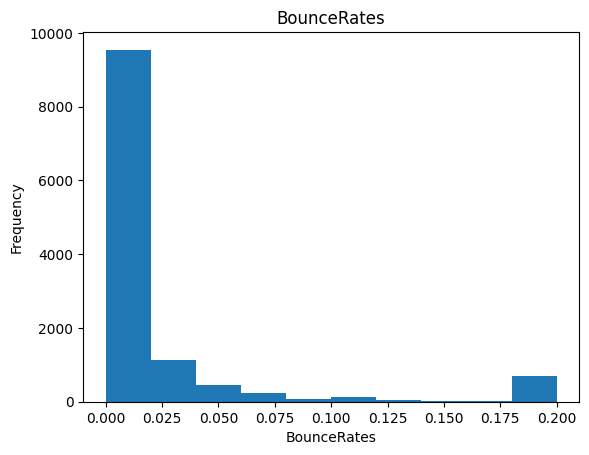

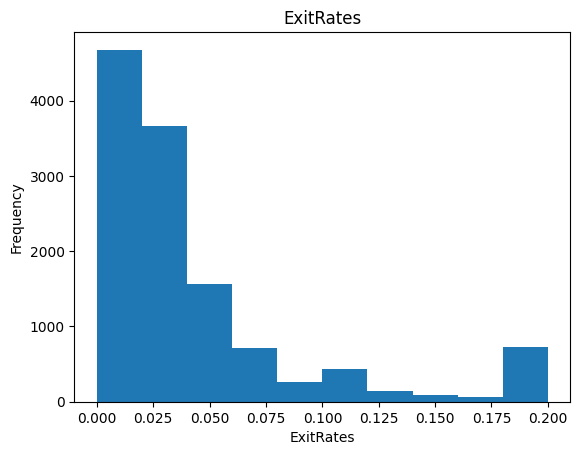

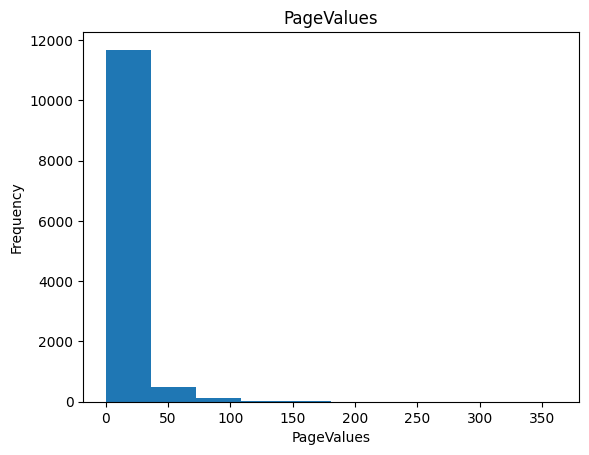

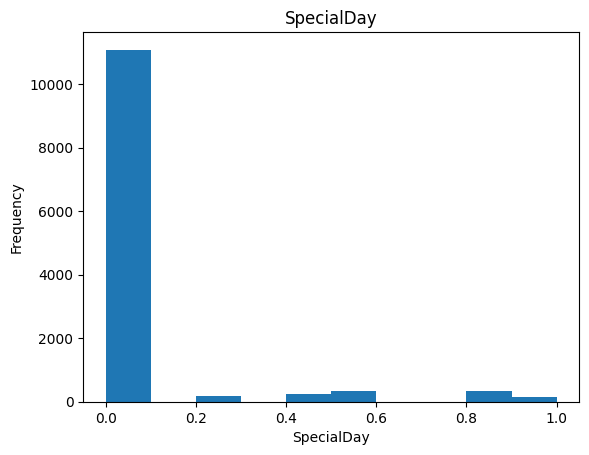

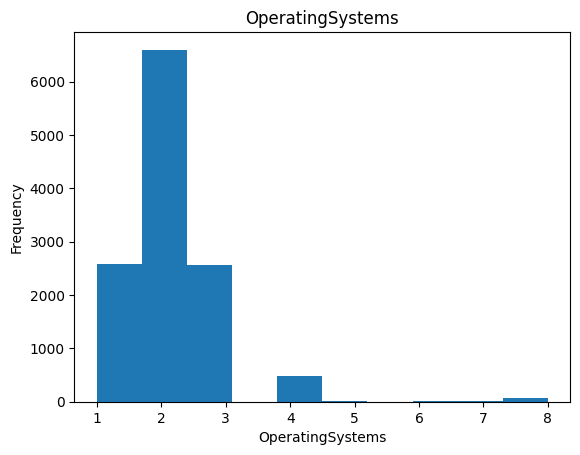

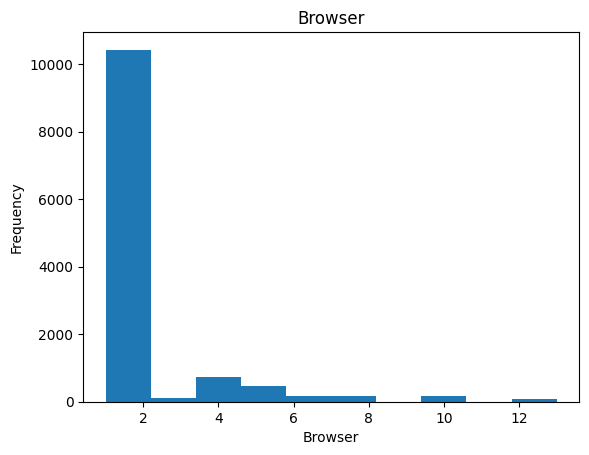

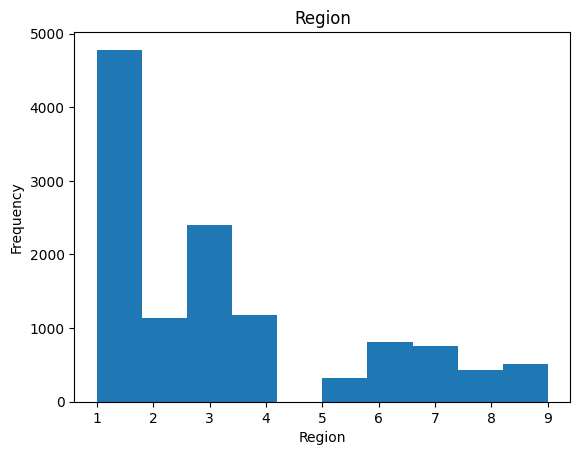

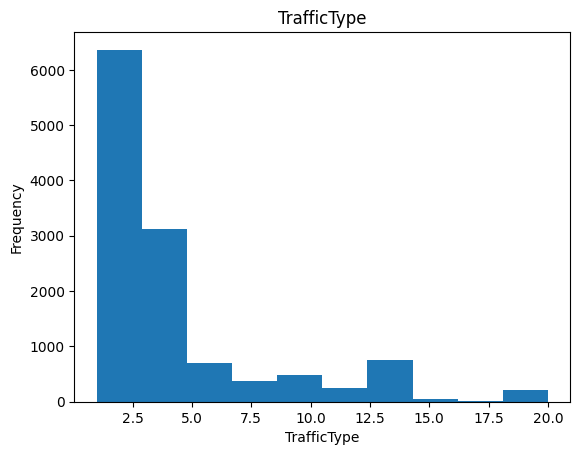

In [3]:
for col in X.columns:
    if (pd.api.types.is_integer_dtype(X[col]) or pd.api.types.is_float_dtype(X[col])):
        plt.figure()
        X[col].plot(kind='hist', title=col)
        plt.xlabel(col)
        plt.show()


In [4]:
# Prep data with one-hot encoding, log-transform, and scaling

X_encoded = pd.get_dummies(X, drop_first=True, dtype=float)

# Identify original numeric columns and apply log1p to reduce skewness
numeric_cols = [col for col in X.columns if pd.api.types.is_integer_dtype(X[col]) or pd.api.types.is_float_dtype(X[col])]
for col in numeric_cols:
    if col in X_encoded.columns:
        # use log1p to handle zeros safely
        X_encoded[col] = np.log1p(X_encoded[col])

# Scale the data
scaler = sk.preprocessing.StandardScaler().fit(X_encoded)
X_scaled = scaler.transform(X_encoded)

In [5]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X_scaled, y, test_size=0.2, random_state=42)
logreg = sk.linear_model.LogisticRegression(max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
mse = sk.metrics.mean_squared_error(y_test, y_pred)
accuracy = sk.metrics.accuracy_score(y_test, y_pred.round())
auc = sk.metrics.roc_auc_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Accuracy:", accuracy)
print("AUC:", auc)

Mean Squared Error: 0.10948905109489052
Accuracy: 0.8905109489051095
AUC: 0.7503649635036496


Fold 1: Accuracy=0.8905, AUC=0.9147 -> saved to cv_models/logreg_fold1.joblib
Fold 2: Accuracy=0.9006, AUC=0.9130 -> saved to cv_models/logreg_fold2.joblib
Fold 3: Accuracy=0.8982, AUC=0.9206 -> saved to cv_models/logreg_fold3.joblib
Fold 4: Accuracy=0.8966, AUC=0.9194 -> saved to cv_models/logreg_fold4.joblib
Fold 5: Accuracy=0.8974, AUC=0.9130 -> saved to cv_models/logreg_fold5.joblib

Summary of folds:
 Fold 1: Acc=0.8905, AUC=0.9147
 Fold 2: Acc=0.9006, AUC=0.9130
 Fold 3: Acc=0.8982, AUC=0.9206
 Fold 4: Acc=0.8966, AUC=0.9194
 Fold 5: Acc=0.8974, AUC=0.9130

Best by accuracy: Fold 2 (Acc=0.9006)
Best by AUC:      Fold 3 (AUC=0.9206)


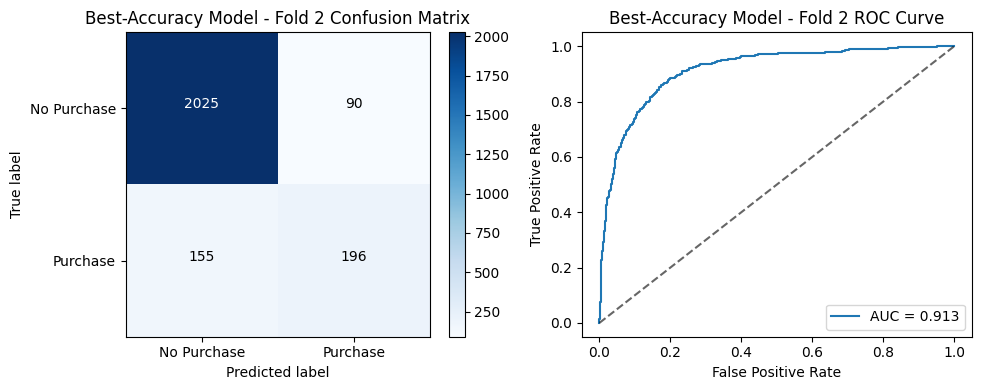

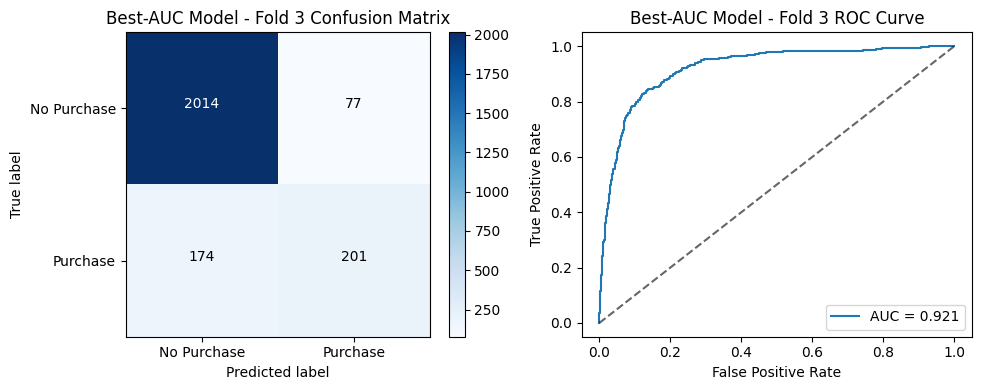

In [6]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve
import numpy as np
import os
import joblib

# Ensure output directory exists
os.makedirs('cv_models', exist_ok=True)

kf = sk.model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
models = []
accs = []
aucs = []
val_indices = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_scaled)):
    # Clone the estimator to ensure a fresh model per fold
    model = clone(logreg)
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]

    model.fit(X_tr, y_tr)

    # Save model to disk
    fname = f"cv_models/logreg_fold{fold_idx + 1}.joblib"
    joblib.dump(model, fname)

    # Predict probabilities (for AUC/ROC) and labels
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        # fallback to decision_function then convert
        scores = model.decision_function(X_val)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        # As a last resort, use predict() and treat as probs (0/1)
        y_proba = model.predict(X_val)

    y_pred = (y_proba >= 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_val, y_pred)
    try:
        auc = roc_auc_score(y_val, y_proba)
    except Exception:
        auc = float('nan')

    models.append(model)
    accs.append(acc)
    aucs.append(auc)
    val_indices.append(val_idx)

    print(f"Fold {fold_idx+1}: Accuracy={acc:.4f}, AUC={auc:.4f} -> saved to {fname}")

# Select best models
best_acc_idx = int(np.nanargmax(accs))
best_auc_idx = int(np.nanargmax(aucs))

print('\nSummary of folds:')
for i, (a, b) in enumerate(zip(accs, aucs), 1):
    print(f" Fold {i}: Acc={a:.4f}, AUC={b:.4f}")

print(f"\nBest by accuracy: Fold {best_acc_idx+1} (Acc={accs[best_acc_idx]:.4f})")
print(f"Best by AUC:      Fold {best_auc_idx+1} (AUC={aucs[best_auc_idx]:.4f})")

# Function to plot confusion matrix and ROC
import matplotlib.pyplot as plt

def plot_results(idx, title_prefix='Model'):
    model = models[idx]
    val_idx = val_indices[idx]
    X_val = X_scaled[val_idx]
    y_val = y[val_idx]

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_val)
        y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
    else:
        y_proba = model.predict(X_val)

    y_pred = (y_proba >= 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{title_prefix} - Fold {idx+1} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Purchase', 'Purchase'])
    plt.yticks(tick_marks, ['No Purchase', 'Purchase'])

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # ROC curve
    plt.subplot(1, 2, 2)
    try:
        fpr, tpr, _ = roc_curve(y_val, y_proba)
        auc_score = roc_auc_score(y_val, y_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
        plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{title_prefix} - Fold {idx+1} ROC Curve")
        plt.legend(loc='lower right')
    except Exception:
        plt.text(0.5, 0.5, 'ROC not available', ha='center')

    plt.tight_layout()
    plt.show()

# Plot for best-accuracy model
plot_results(best_acc_idx, title_prefix='Best-Accuracy Model')

# Plot for best-AUC model (if different)
if best_auc_idx != best_acc_idx:
    plot_results(best_auc_idx, title_prefix='Best-AUC Model')
else:
    print('\nBest-accuracy and best-AUC models are the same fold.')

In [8]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_scaled.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', # Use for integer labels
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 5. Evaluate the model (optional)
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# 6. Make predictions (optional)
predictions = model.predict(X_test)

c:\Users\azhan\Desktop\hw\OnlinePurchaseRetentionSTAT441\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8856 - loss: 0.2648 - val_accuracy: 0.8901 - val_loss: 0.2506
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8856 - loss: 0.2648 - val_accuracy: 0.8901 - val_loss: 0.2506
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9029 - loss: 0.2279 - val_accuracy: 0.8909 - val_loss: 0.2588
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9029 - loss: 0.2279 - val_accuracy: 0.8909 - val_loss: 0.2588
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9035 - loss: 0.2198 - val_accuracy: 0.8929 - val_loss: 0.2493
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9035 - loss: 0.2198 - val_accuracy: 0.8929 - val_loss: 0.2493
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2133 - val_accuracy: 0.8942 - val_loss: 0.2451
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.2133 - val_accuracy: 0.

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step

Neural Network Performance:
AUC Score: 0.9198
Confusion Matrix:
[[1909  146]
 [ 129  282]]

Neural Network Performance:
AUC Score: 0.9198
Confusion Matrix:
[[1909  146]
 [ 129  282]]


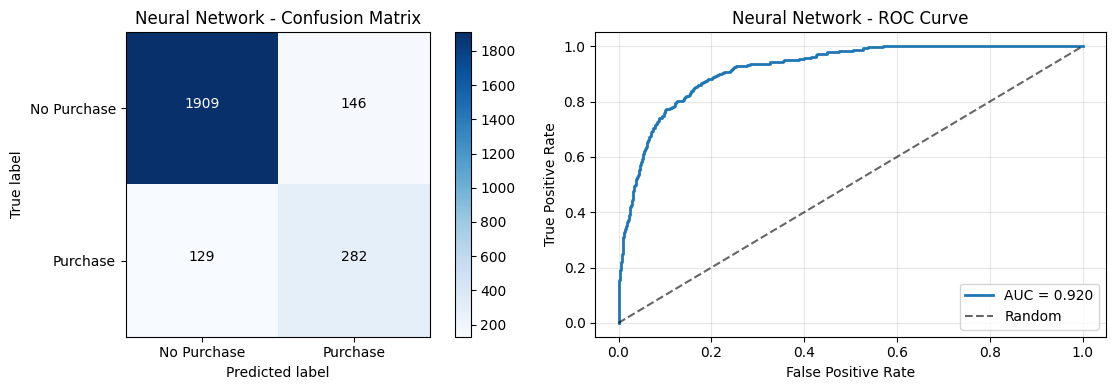

In [9]:

# Compute confusion matrix and ROC curve for Neural Network
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Get probability predictions for the test set
y_nn_proba = model.predict(X_test)

# Handle output shape (model outputs 2 classes, take the probability of class 1)
if y_nn_proba.shape[1] == 2:
    y_nn_proba_class1 = y_nn_proba[:, 1]
else:
    y_nn_proba_class1 = y_nn_proba.flatten()

# Get binary predictions using 0.5 threshold
y_nn_pred = (y_nn_proba_class1 >= 0.5).astype(int)

# Compute metrics
nn_cm = confusion_matrix(y_test, y_nn_pred)
nn_auc = roc_auc_score(y_test, y_nn_proba_class1)

print(f"\nNeural Network Performance:")
print(f"AUC Score: {nn_auc:.4f}")
print(f"Confusion Matrix:\n{nn_cm}")

# Plot confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion Matrix
ax1 = axes[0]
im = ax1.imshow(nn_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title('Neural Network - Confusion Matrix')
plt.colorbar(im, ax=ax1)
tick_marks = np.arange(2)
ax1.set_xticks(tick_marks)
ax1.set_yticks(tick_marks)
ax1.set_xticklabels(['No Purchase', 'Purchase'])
ax1.set_yticklabels(['No Purchase', 'Purchase'])

thresh = nn_cm.max() / 2.
for i in range(nn_cm.shape[0]):
    for j in range(nn_cm.shape[1]):
        ax1.text(j, i, format(nn_cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if nn_cm[i, j] > thresh else "black")

ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')

# ROC Curve
ax2 = axes[1]
fpr, tpr, _ = roc_curve(y_test, y_nn_proba_class1)
ax2.plot(fpr, tpr, label=f'AUC = {nn_auc:.3f}', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Neural Network - ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Random Forest Classification Implementation
randomForest = sk.ensemble.RandomForestClassifier()
randomForest.fit(X_train, y_train)
y_rf = randomForest.predict(X_test) # The predicted y values from our random forest model
rf_mse = sk.metrics.mean_squared_error(y_test, y_rf)
rf_accuracy = sk.metrics.accuracy_score(y_test, y_rf.round())
rf_auc = sk.metrics.roc_auc_score(y_test, y_rf)
print("Mean Squared Error from Random Forrest:", rf_mse)
print("Accuracy from Random Forrest:", rf_accuracy)
print("AUC from Random Forrest:", rf_auc)

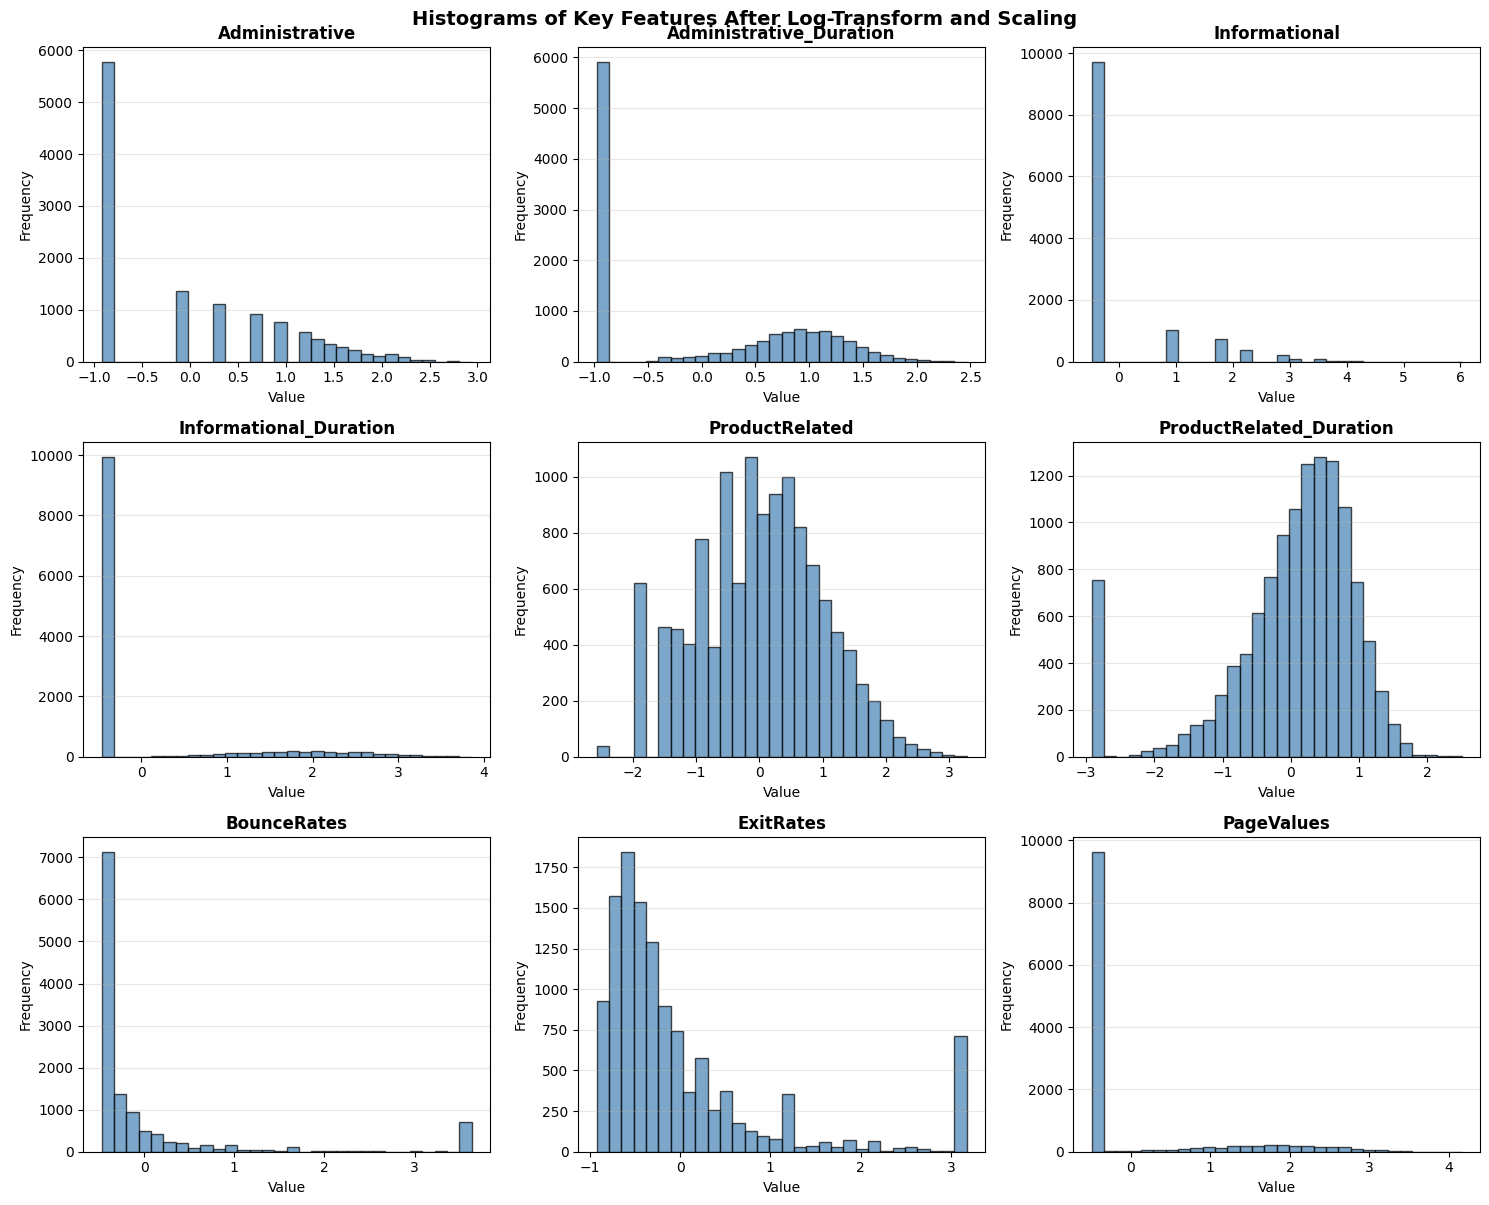

In [11]:

# Plot histograms of selected key features after log-transform and scaling
selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                     'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
                     'BounceRates', 'ExitRates', 'PageValues']

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(selected_features):
    if col in X_scaled_df.columns:
        axes[idx].hist(X_scaled_df[col], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Histograms of Key Features After Log-Transform and Scaling', fontsize=14, fontweight='bold', y=1.00)
plt.show()


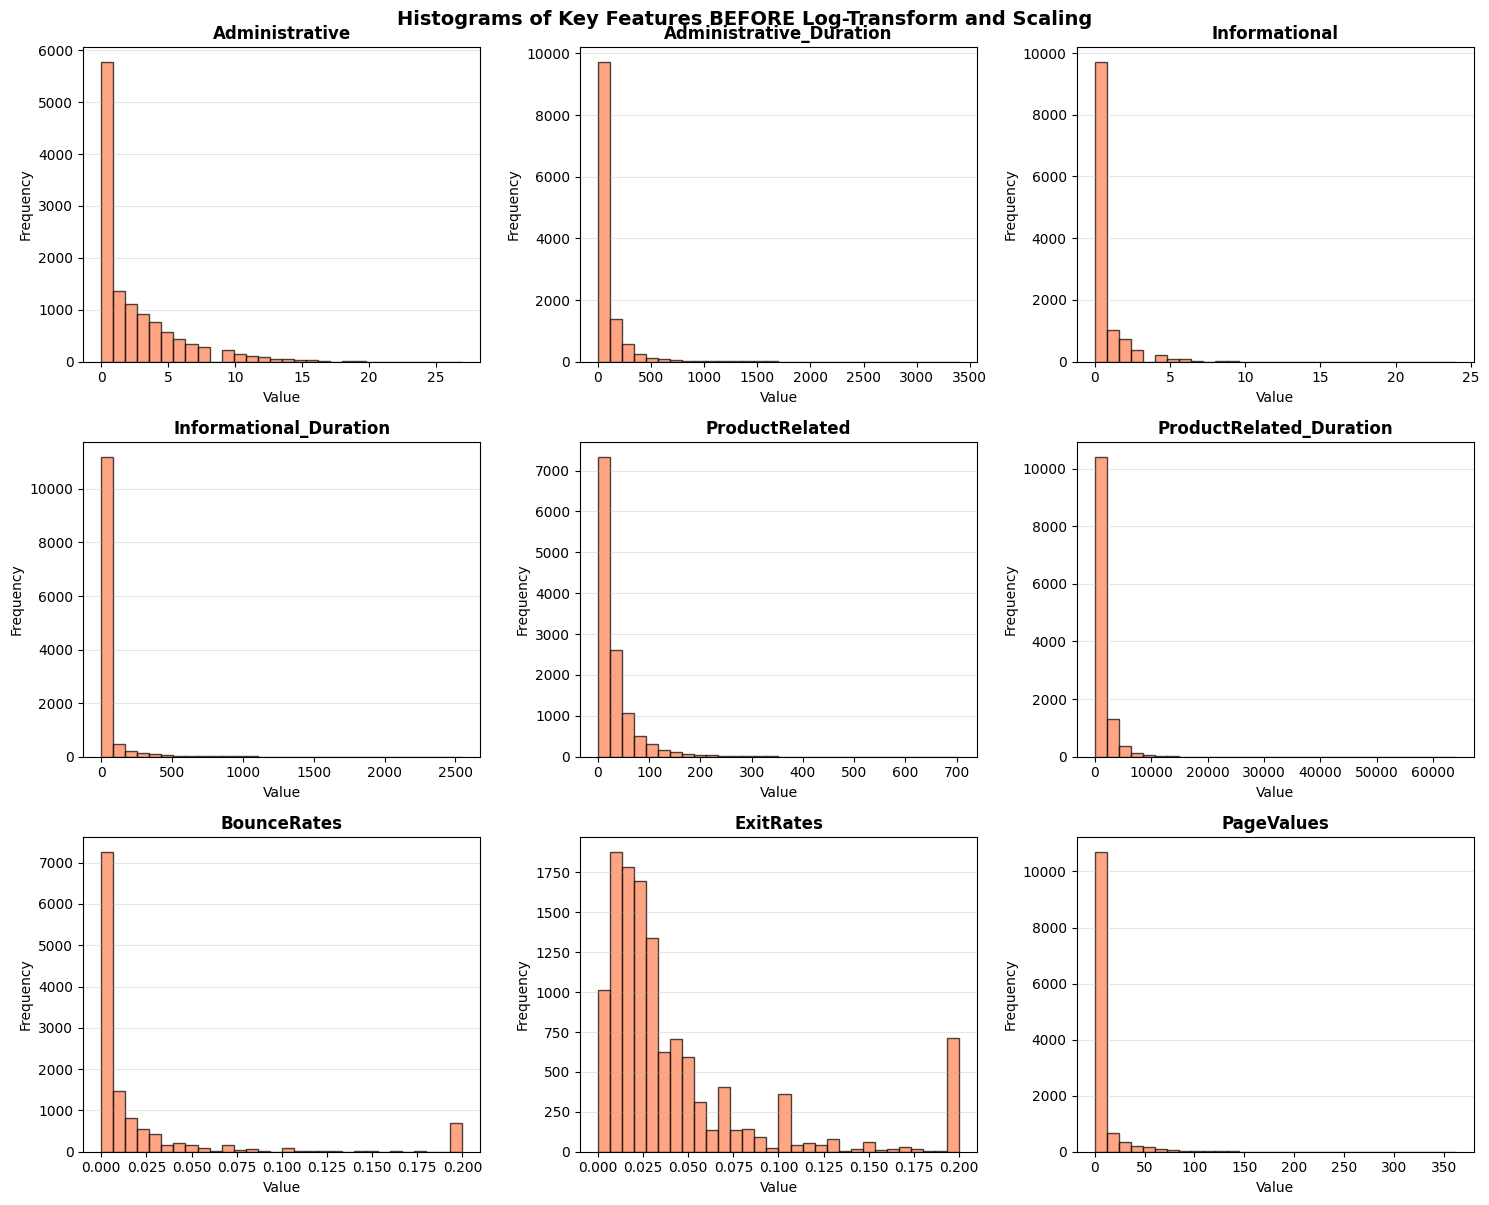

In [12]:

# Plot histograms of selected key features BEFORE log-transform and scaling
selected_features = ['Administrative', 'Administrative_Duration', 'Informational', 
                     'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 
                     'BounceRates', 'ExitRates', 'PageValues']

# Create a 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(selected_features):
    if col in X.columns:
        axes[idx].hist(X[col], bins=30, edgecolor='black', alpha=0.7, color='coral')
        axes[idx].set_title(f'{col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Frequency', fontsize=10)
        axes[idx].set_xlabel('Value', fontsize=10)
        axes[idx].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Histograms of Key Features BEFORE Log-Transform and Scaling', fontsize=14, fontweight='bold', y=1.00)
plt.show()


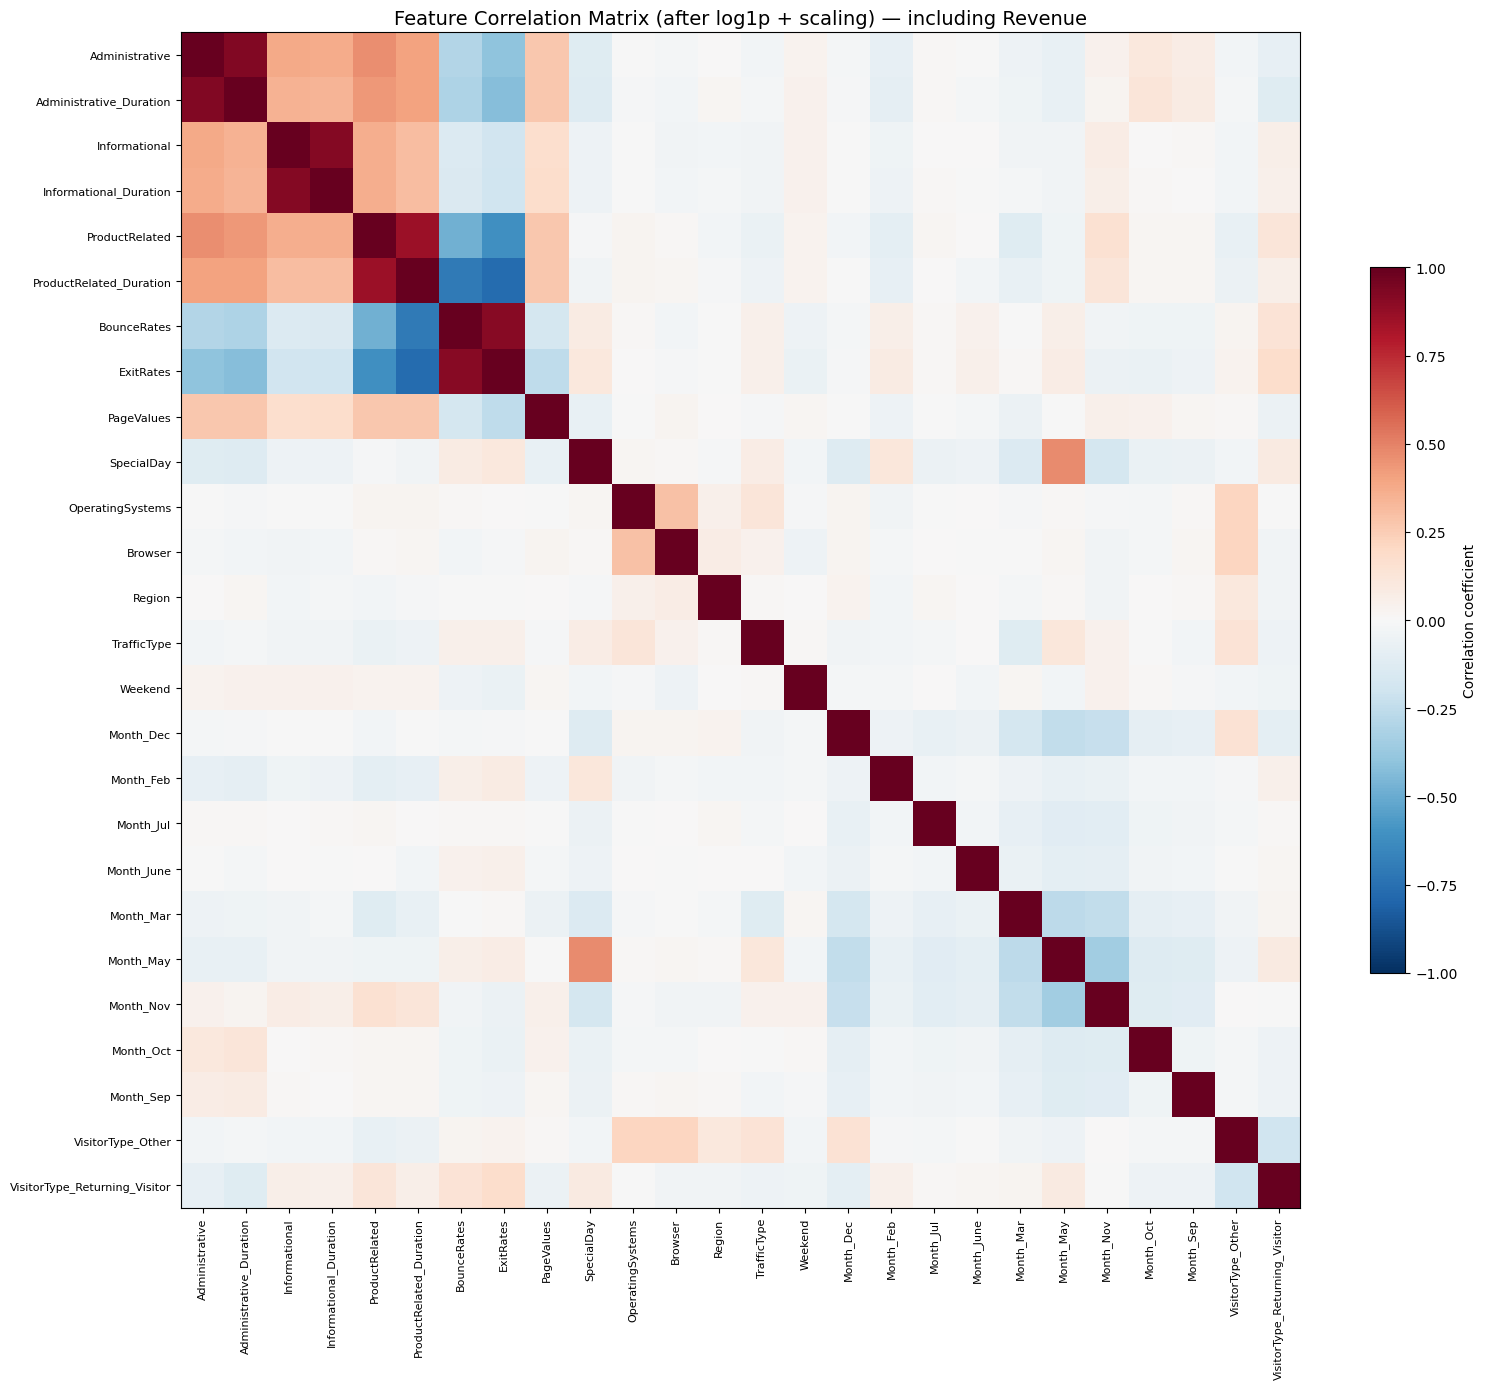


Top 10 positive correlations (feature pairs):
Administrative <-> Administrative_Duration: 0.925
Informational <-> Informational_Duration: 0.918
ExitRates <-> BounceRates: 0.907
ProductRelated <-> ProductRelated_Duration: 0.857
Month_May <-> SpecialDay: 0.475
ProductRelated <-> Administrative: 0.468
Administrative_Duration <-> ProductRelated: 0.434
Administrative_Duration <-> ProductRelated_Duration: 0.402
Administrative <-> ProductRelated_Duration: 0.402
Informational <-> Administrative: 0.381

Top 10 negative correlations (feature pairs):
ProductRelated_Duration <-> ExitRates: -0.773
BounceRates <-> ProductRelated_Duration: -0.707
ExitRates <-> ProductRelated: -0.617
ProductRelated <-> BounceRates: -0.478
Administrative_Duration <-> ExitRates: -0.427
ExitRates <-> Administrative: -0.404
Month_May <-> Month_Nov: -0.347
BounceRates <-> Administrative_Duration: -0.309
Administrative <-> BounceRates: -0.291
Month_May <-> Month_Mar: -0.262


In [14]:
# Full feature correlation heatmap (after log-transform and scaling) including Revenue
# Computes correlations between all features (including the target) and plots a heatmap.
try:
    import seaborn as sns
    _sns_available = True
except Exception:
    _sns_available = False

# Prepare correlation matrix including Revenue (if present)
_corr_df = X_scaled_df.corr()

if _sns_available:
    plt.figure(figsize=(16, 14))
    sns.heatmap(_corr_df, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
                square=False, linewidths=0.1, cbar_kws={'shrink': 0.6})
    plt.title('Feature Correlation Matrix (after log1p + scaling) — including Revenue', fontsize=14)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    # Fallback: matplotlib imshow
    fig, ax = plt.subplots(figsize=(16, 14))
    im = ax.imshow(_corr_df.values, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
    ax.set_xticks(range(len(_corr_df.columns)))
    ax.set_xticklabels(_corr_df.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(len(_corr_df.index)))
    ax.set_yticklabels(_corr_df.index, fontsize=8)
    cbar = fig.colorbar(im, ax=ax, shrink=0.6)
    cbar.set_label('Correlation coefficient')
    plt.title('Feature Correlation Matrix (after log1p + scaling) — including Revenue', fontsize=14)
    plt.tight_layout()
    plt.show()

# Print top positively and negatively correlated feature pairs (including Revenue) for quick inspection
print('\nTop 10 positive correlations (feature pairs):')
_corr_unstack = _corr_df.where(~np.eye(_corr_df.shape[0], dtype=bool)).unstack().dropna()
_corr_sorted = _corr_unstack.sort_values(ascending=False)
seen = set()
count = 0
for (f1, f2), val in _corr_sorted.items():
    # avoid duplicate pairs
    if (f2, f1) in seen:
        continue
    seen.add((f1, f2))
    print(f"{f1} <-> {f2}: {val:.3f}")
    count += 1
    if count >= 10:
        break

print('\nTop 10 negative correlations (feature pairs):')
_corr_sorted_neg = _corr_unstack.sort_values(ascending=True)
seen = set()
count = 0
for (f1, f2), val in _corr_sorted_neg.items():
    if (f2, f1) in seen:
        continue
    seen.add((f1, f2))
    print(f"{f1} <-> {f2}: {val:.3f}")
    count += 1
    if count >= 10:
        break
